<a href="https://colab.research.google.com/github/AnnPike/final-project-ML/blob/master/nets_to_compurte_smoothness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
save_to = "/content/gdrive/My Drive/nets_to_compute_smoothness/"

# Loadind data and function defininitions

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience or if training loss doesn't improve after a given t_patience"""
    def __init__(self, patience=7, t_patience=10, verbose=False, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            t_patience  (int): How long to wait after train loss is not improving
                            Deafault: 10
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.t_patience = t_patience
        self.verbose = verbose
        self.counter = 0
        self.t_counter = 0
        self.best_score = None
        self.t_best_score = None
        self.early_stop = False
        self.t_early_stop = False
        self.val_loss_min = np.Inf
        self.path = path

    def __call__(self, val_loss, train_loss, model):

        score = val_loss
        t_score = train_loss
        if self.best_score is None:
          self.best_score = score
          self.save_checkpoint(val_loss, model)
        elif score > self.best_score:
          self.counter += 1
          if self.counter >= self.patience:
            self.early_stop = True
        else:
          self.best_score = score
          self.save_checkpoint(val_loss, model)
          self.counter = 0
        if self.t_best_score is None:
          self.t_best_score = t_score
        elif t_score < self.t_best_score:
          self.t_best_score = t_score
          self.t_counter = 0
        else:
          self.t_counter +=1
          if self.t_counter >= self.t_patience:
              self.t_early_stop = True
        
    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
import torch
import numpy as np
import time

from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from torchvision.transforms import Normalize



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 250
valid_size = 0.2
transform = Compose([ToTensor(), Normalize((0.4914, 0.4822, 0.4465), (1,1,1))])

train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

all_train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

num_train = len(train_data)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

cuda:0
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
num_epochs = 100
patience = 3

#train model with early stopping
def train_model(model, batch_size, patience, num_epochs, model_name, verbose=False):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience,t_patience=50, verbose=False)
    
    for epoch in range(1, num_epochs + 1):
        model_save_name = model_name+'.pt'

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            data = data.to(device)
            target = target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        with torch.no_grad():
          for data, target in valid_loader:
              data = data.to(device)
              target = target.to(device)
              # forward pass: compute predicted outputs by passing inputs to the model
              output = model(data)
              # calculate the loss
              loss = criterion(output, target)
              # record validation loss
              valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        if verbose:
          epoch_len = len(str(num_epochs))
          print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                      f'train_loss: {train_loss:.5f} ' +
                      f'valid_loss: {valid_loss:.5f}')
          print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, train_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        if early_stopping.t_early_stop:
            print("Not improving")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))   
    path = save_to+model_save_name
    torch.save(model.state_dict(), path)

    # plot learning curves
    E = epoch-patience
    print(F"epochs: {E}")
    plt.plot(range(1,epoch+1),avg_train_losses,'y',label = 'average train loss per batch')
    plt.plot(range(1,epoch+1),avg_valid_losses,'b', label = 'average valid loss per batch')   
    plt.axvline(x=E, color ='r', linestyle ="--", linewidth = 1, label = 'early stopping')
    plt.legend()
    plt.show()
    return  model

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def eval_model(model, model_name):
  PREDICT = torch.empty(0).to(device)
  CORRECT = torch.empty(0).to(device)
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  model.eval()
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
       # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      loss = criterion(output, target)
      _, pred = torch.max(output,1)
      PREDICT = torch.cat([PREDICT,pred],axis=0)
      CORRECT = torch.cat([CORRECT,target],axis=0)

  cf_matrix = confusion_matrix(CORRECT.cpu(), PREDICT.cpu())
  cf_matrix_pc = (cf_matrix/cf_matrix.sum(axis=0))*100
  sns.heatmap(cf_matrix_pc, annot=True,cmap='Blues', xticklabels=classes, yticklabels=classes)
  plt.title('confusuin matrix for test predictions in percent')
  plt.show()
  accuracy = accuracy_score(CORRECT.cpu(), PREDICT.cpu())
  precision, recall, _, __ = precision_recall_fscore_support(CORRECT.cpu(), PREDICT.cpu(), average='macro')
  print(f"Macro precision: {precision:.4f}\nMacro recall: {recall:.4f}\nAccuracy: {accuracy*100:.2f} %")

In [ ]:
#to extract convolved images
import pickle
def get_activation(name):
    def hook(model, input, output):
      if name in dict_X:
        X = dict_X[name]
        dict_X[name] = torch.cat([X,output.reshape(batch_size,-1).to(device)],axis=0)
      else:
        dict_X[name] = output.reshape(batch_size,-1).to(device)
    return hook

# ResNet4

Early stopping
epochs: 31


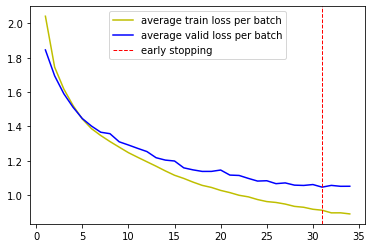

--- 4.703085549672445 minuts ---


In [ ]:
model_name = 'ResNet4'
class ResNet4(nn.Module):
  def __init__(self):
    super(ResNet4,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*16,10)
  def forward(self, x):
    x = self.conv1(x) #16*16*16
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv2(x)) 
    x = self.conv3(x)
    x = x + identity
    x = F.relu(x)
    x = self.avpool(x)
    x = x.view(-1,16*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet4()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

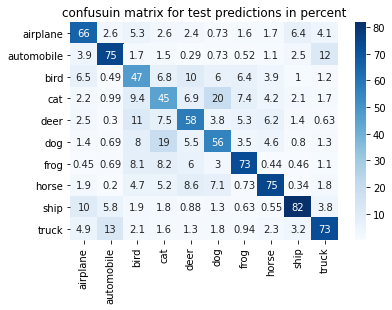

Macro precision: 0.6507
Macro recall: 0.6438
Accuracy: 64.38 %


In [ ]:
eval_model(model, model_name)

In [ ]:
#register hook for every layer
layer_names = ['conv1', 'conv2', 'conv3', 'avpool', 'fc1']

dict_X = {}
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv3.register_forward_hook(get_activation('conv3'))
model.avpool.register_forward_hook(get_activation('avpool'))
model.fc1.register_forward_hook(get_activation('fc1'))

with torch.no_grad():
  for input, _ in all_train_loader:
    input = input.to(device)
    output = model(input)

In [ ]:
for layer in layer_names:
  print(layer+': ', dict_X[layer].shape)
#save output for each layer
m = nn.ReLU()

pickle.dump(m(dict_X['conv1']).cpu().numpy(), open(save_to+model_name+'_conv1_relu','wb'))

pickle.dump(m(dict_X['conv2']).cpu().numpy(), open(save_to+model_name+'_conv2_relu','wb'))
del dict_X['conv2']

pickle.dump(m(dict_X['conv3']+dict_X['conv1']).cpu().numpy(), open(save_to+model_name+'_conv3+identity_relu','wb'))
del dict_X['conv1']
del dict_X['conv3']

pickle.dump(dict_X['avpool'].cpu().numpy(), open(save_to+model_name+'_avpool','wb'))
del dict_X['avpool']

pickle.dump(dict_X['fc1'].cpu().numpy(), open(save_to+model_name+'_fc1','wb'))
del dict_X['fc1']

conv1:  torch.Size([50000, 4096])
conv2:  torch.Size([50000, 4096])
conv3:  torch.Size([50000, 4096])
avpool:  torch.Size([50000, 1024])
fc1:  torch.Size([50000, 10])


Early stopping
epochs: 25


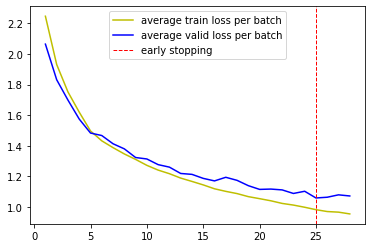

--- 4.0071775635083515 minuts ---


In [ ]:
model_name = 'Plain4'
class Plain4(nn.Module):
  def __init__(self):
    super(Plain4,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*16,10)
  def forward(self, x):
    x = self.conv1(x) #16*16*16
    x = F.relu(x)
    x = F.relu(self.conv2(x)) 
    x = self.conv3(x)
    x = F.relu(x)
    x = self.avpool(x)
    x = x.view(-1,16*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = Plain4()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

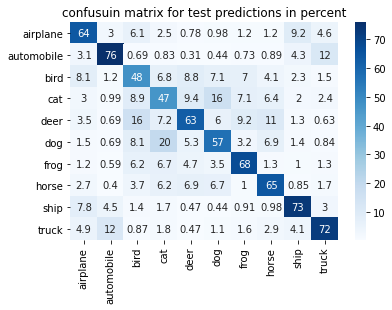

Macro precision: 0.6336
Macro recall: 0.6335
Accuracy: 63.35 %


In [ ]:
eval_model(model, model_name)

In [ ]:
#register hook for every layer
layer_names = ['conv1', 'conv2', 'conv3', 'avpool', 'fc1']

model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv3.register_forward_hook(get_activation('conv3'))
model.avpool.register_forward_hook(get_activation('avpool'))
model.fc1.register_forward_hook(get_activation('fc1'))

with torch.no_grad():
  for input, _ in all_train_loader:
    input = input.to(device)
    output = model(input)

In [ ]:
for layer in layer_names:
  print(layer+': ', dict_X[layer].shape)
#save output for each layer
m = nn.ReLU()

pickle.dump(m(dict_X['conv1']).cpu().numpy(), open(save_to+model_name+'_conv1_relu','wb'))
del dict_X['conv1']

pickle.dump(m(dict_X['conv2']).cpu().numpy(), open(save_to+model_name+'_conv2_relu','wb'))
del dict_X['conv2']

pickle.dump(m(dict_X['conv3']).cpu().numpy(), open(save_to+model_name+'_conv3_relu','wb'))
del dict_X['conv3']

pickle.dump(dict_X['avpool'].cpu().numpy(), open(save_to+model_name+'_avpool','wb'))
del dict_X['avpool']

pickle.dump(dict_X['fc1'].cpu().numpy(), open(save_to+model_name+'_fc1','wb'))
del dict_X['fc1']

conv1:  torch.Size([50000, 4096])
conv2:  torch.Size([50000, 4096])
conv3:  torch.Size([50000, 4096])
avpool:  torch.Size([50000, 1024])
fc1:  torch.Size([50000, 10])


# ResNet6


Early stopping
epochs: 25


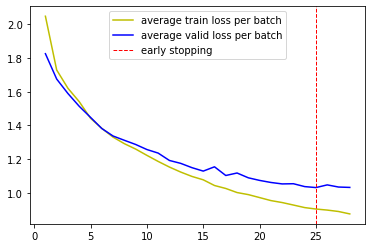

--- 4.188406606515248 minuts ---


In [ ]:
model_name = 'ResNet6'
class ResNet6(nn.Module):
  def __init__(self):
    super(ResNet6,self).__init__()
    self.conv1 = nn.Conv2d(3, 8, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(8, 16, 3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*16,10)
  def forward(self, x):
    padding_zeros_8 = torch.zeros(batch_size,8,16,16).to(device)
    x = self.conv1(x) #8*16*16
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv2(x)) 
    x = self.conv3(x)
    x = x + identity
    identity = x.clone()
    x = F.relu(x)
    x = F.relu(self.conv4(x)) #16*16*16
    x = self.conv5(x) 
    x = x +  torch.cat([identity,padding_zeros_8],axis=1)
    x = F.relu(x)
    x = self.avpool(x)
    x = x.view(-1,16*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet6()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

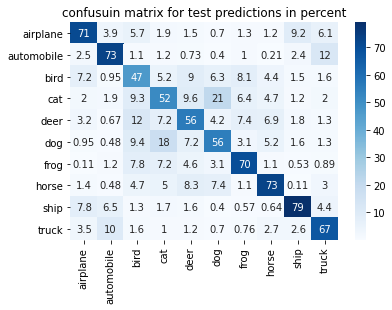

Macro precision: 0.6446
Macro recall: 0.6433
Accuracy: 64.33 %


In [ ]:
eval_model(model, model_name)

In [ ]:
#register hook for every layer
layer_names = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'avpool', 'fc1']

model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv3.register_forward_hook(get_activation('conv3'))
model.conv4.register_forward_hook(get_activation('conv4'))
model.conv5.register_forward_hook(get_activation('conv5'))
model.avpool.register_forward_hook(get_activation('avpool'))
model.fc1.register_forward_hook(get_activation('fc1'))

with torch.no_grad():
  for input, _ in all_train_loader:
    input = input.to(device)
    output = model(input)

In [ ]:
for layer in layer_names:
  print(layer+': ', dict_X[layer].shape)
#save output for each layer
m = nn.ReLU()

pickle.dump(m(dict_X['conv1']).cpu().numpy(), open(save_to+model_name+'_conv1_relu','wb'))

pickle.dump(m(dict_X['conv2']).cpu().numpy(), open(save_to+model_name+'_conv2_relu','wb'))
del dict_X['conv2']

conv3_plus_identity = dict_X['conv3'].clone()+dict_X['conv1'].clone()
pickle.dump(m(conv3_plus_identity).cpu().numpy(), open(save_to+model_name+'_conv3+identity_relu','wb'))
del dict_X['conv1']
del dict_X['conv3']

pickle.dump(m(dict_X['conv4']).cpu().numpy(), open(save_to+model_name+'_conv4_relu','wb'))
del dict_X['conv4']

padding_zeros = torch.zeros(50000,2048).to(device)
pickle.dump(m(dict_X['conv5']+torch.cat([conv3_plus_identity,padding_zeros],axis=1)).cpu().numpy(), open(save_to+model_name+'_conv5+identity_relu','wb'))
del dict_X['conv5']
del conv3_plus_identity

pickle.dump(dict_X['avpool'].cpu().numpy(), open(save_to+model_name+'_avpool','wb'))
del dict_X['avpool']

pickle.dump(dict_X['fc1'].cpu().numpy(), open(save_to+model_name+'_fc1','wb'))
del dict_X['fc1']

conv1:  torch.Size([50000, 2048])
conv2:  torch.Size([50000, 2048])
conv3:  torch.Size([50000, 2048])
conv4:  torch.Size([50000, 4096])
conv5:  torch.Size([50000, 4096])
avpool:  torch.Size([50000, 1024])
fc1:  torch.Size([50000, 10])


Early stopping
epochs: 30


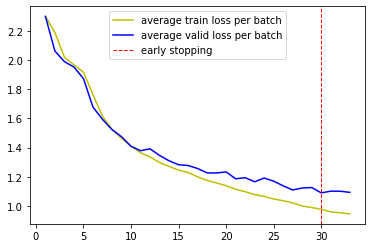

--- 4.881868390242259 minuts ---


In [ ]:
model_name = 'Plain6'
class Plain6(nn.Module):
  def __init__(self):
    super(Plain6,self).__init__()
    self.conv1 = nn.Conv2d(3, 8, 4, padding=1,stride=2, bias=False)
    self.conv2 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv3 = nn.Conv2d(8, 8, 3, padding=1, bias=False)
    self.conv4 = nn.Conv2d(8, 16, 3, padding=1, bias=False)
    self.conv5 = nn.Conv2d(16, 16, 3, padding=1, bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*16,10)
  def forward(self, x):
    x = self.conv1(x) #8*16*16
    x = F.relu(x)
    x = F.relu(self.conv2(x)) 
    x = self.conv3(x)
    x = F.relu(x)
    x = F.relu(self.conv4(x)) #16*16*16
    x = self.conv5(x) 
    x = F.relu(x)
    x = self.avpool(x)
    x = x.view(-1,16*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = Plain6()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

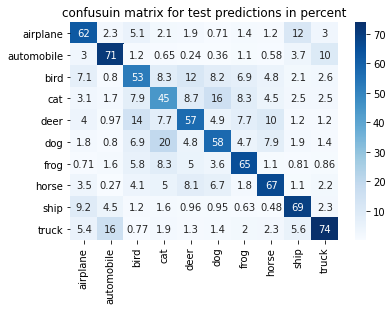

Macro precision: 0.6210
Macro recall: 0.6223
Accuracy: 62.23 %


In [ ]:
eval_model(model, model_name)

In [ ]:
#register hook for every layer
layer_names = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'avpool', 'fc1']

model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv3.register_forward_hook(get_activation('conv3'))
model.conv4.register_forward_hook(get_activation('conv4'))
model.conv5.register_forward_hook(get_activation('conv5'))
model.avpool.register_forward_hook(get_activation('avpool'))
model.fc1.register_forward_hook(get_activation('fc1'))

with torch.no_grad():
  for input, _ in all_train_loader:
    input = input.to(device)
    output = model(input)

In [ ]:
for layer in layer_names:
  print(layer+': ', dict_X[layer].shape)
#save output for each layer
m = nn.ReLU()

pickle.dump(m(dict_X['conv1']).cpu().numpy(), open(save_to+model_name+'_conv1_relu','wb'))
del dict_X['conv1']

pickle.dump(m(dict_X['conv2']).cpu().numpy(), open(save_to+model_name+'_conv2_relu','wb'))
del dict_X['conv2']

pickle.dump(m(dict_X['conv3']).cpu().numpy(), open(save_to+model_name+'_conv3_relu','wb'))
del dict_X['conv3']

pickle.dump(m(dict_X['conv4']).cpu().numpy(), open(save_to+model_name+'_conv4_relu','wb'))
del dict_X['conv4']

pickle.dump(m(dict_X['conv5']).cpu().numpy(), open(save_to+model_name+'_conv5_relu','wb'))
del dict_X['conv5']

pickle.dump(dict_X['avpool'].cpu().numpy(), open(save_to+model_name+'_avpool','wb'))
del dict_X['avpool']

pickle.dump(dict_X['fc1'].cpu().numpy(), open(save_to+model_name+'_fc1','wb'))
del dict_X['fc1']

conv1:  torch.Size([50000, 2048])
conv2:  torch.Size([50000, 2048])
conv3:  torch.Size([50000, 2048])
conv4:  torch.Size([50000, 4096])
conv5:  torch.Size([50000, 4096])
avpool:  torch.Size([50000, 1024])
fc1:  torch.Size([50000, 10])


Adding resblocks didn't improve significantly a test accuracy, adding res fullyconected block didnt improve test accuracy, adding a fully conected layer of a size 100 didnt imporove the test accuracy.
 